In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201020"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str18,str11,object,float64,int64,int64
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024
Bias-005.fit,Bias Frame,--,0.0,1024,1024
Bias-006.fit,Bias Frame,--,0.0,1024,1024
Bias-007.fit,Bias Frame,--,0.0,1024,1024
Bias-008.fit,Bias Frame,--,0.0,1024,1024
Bias-009.fit,Bias Frame,--,0.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [5]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [6]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel R', 'Bessel V'}

In [7]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

797.9553508758545 1.4826
793.5 806.2706836313675


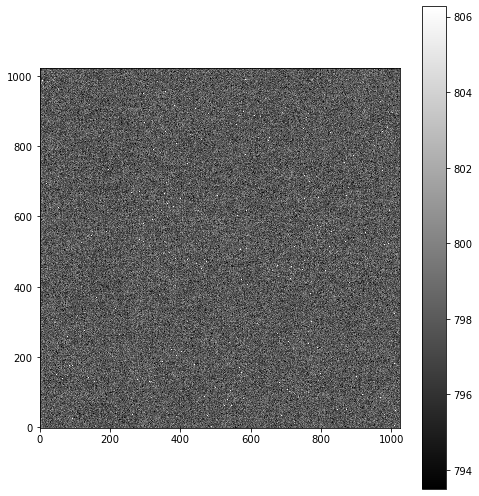

In [8]:
show_image(combined_bias)

0.41453375021616623 0.061775000000000024
0.175 0.736481404003572


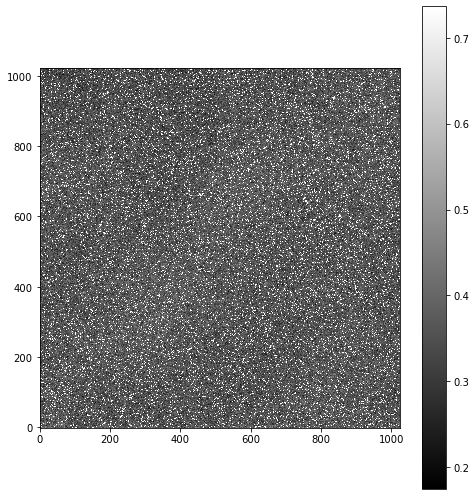

In [9]:
show_image(combined_darks)

1.0000645428171333 0.005965664176103558
0.967946647177051 1.0277244655581947


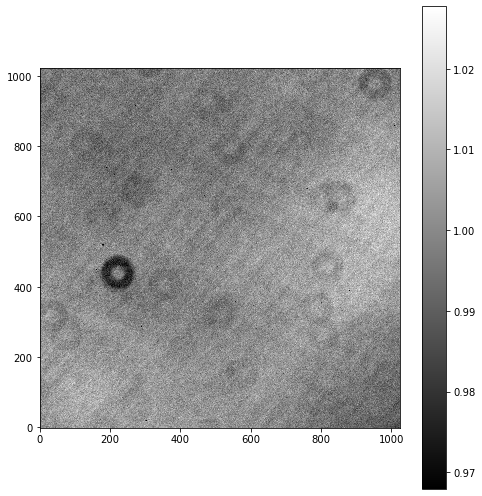

1.0032853840123814 0.010103322207959026
0.9693325120417685 1.0536913524783724


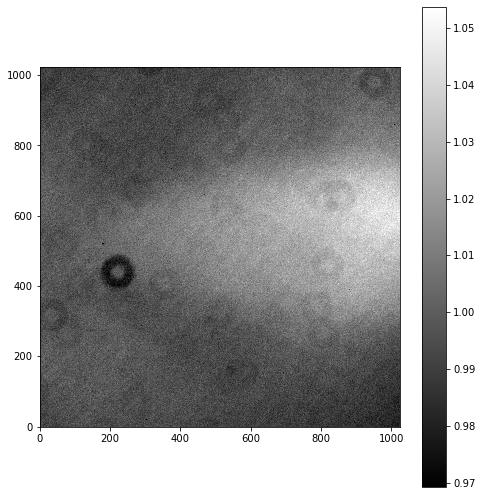

In [10]:
for filt,image in master_flats.items():
    show_image(image)

In [11]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
297.41358116491676 12.615377701044709
236.92255566792036 371.81573950654837


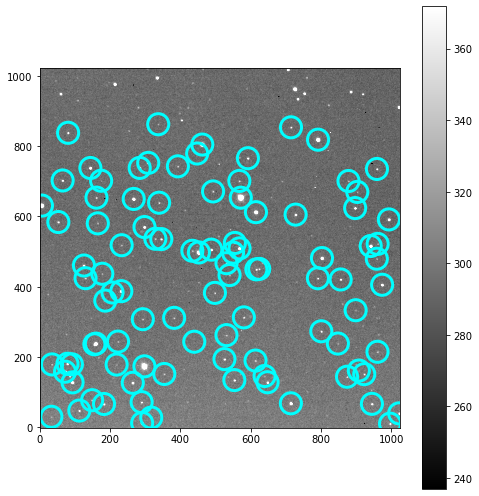

     xcentroid   ycentroid       mag
78  571.666698  653.488237 -6.723142
21  297.491920  173.627702 -6.513826
57  452.445358  497.664013 -4.957225
92  462.032201  804.718153 -4.893269
74    5.819304  631.049993 -4.843958
..         ...         ...       ...
16  639.333681  146.190173 -0.058060
39  898.447007  333.285405 -0.052062
20  907.473127  161.644076 -0.020593
84  174.332392  701.704325 -0.018299
23   91.030755  179.384241 -0.013134

[97 rows x 3 columns]
Point RA 23 41 55
Point Dec +44 10 36
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.47916667, 44.17666667)>
radecstr 355.479 44.1767
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
355.64099415478967  44.127721

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.55959659e+02 1.60044089e+00 2.74432040e-01]
dyfit [ 5.46863653e+02 -2.74853242e-01  1.59965328e+00]

scalex, scaley: 0.6158396772100503 0.6161071704938784
anglex, angley: -9.730038914921279 -9.749392449724544
fracdiffs: 0.001989050092449745 0.0004343553910653579

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And-001V.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And-001V.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And-001V.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And-001V.match.transfo

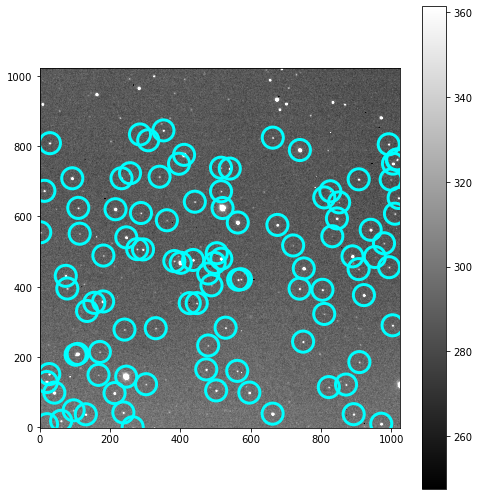

     xcentroid   ycentroid       mag
76  519.875596  624.100207 -6.802812
17  245.635236  144.306663 -6.505612
50  400.653620  468.282298 -4.935102
96  410.263832  775.312729 -4.840330
97  739.676147  789.071032 -4.464460
..         ...         ...       ...
32  809.007910  322.752447 -0.029264
65  113.291822  551.051515 -0.021190
55  953.028878  484.823247 -0.008168
1    20.287909    9.064346 -0.005976
91  515.322663  738.773538 -0.003187

[104 rows x 3 columns]
Point RA 23 41 58
Point Dec +44 11 06
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.49166667, 44.185)>
radecstr 355.492 44.185
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
355.64099415478967  44.12772121179

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.66086634e+02 1.59997078e+00 2.74617163e-01]
dyfit [ 5.56057744e+02 -2.74872996e-01  1.59956395e+00]

scalex, scaley: 0.6160035748975905 0.6161393205226484
anglex, angley: -9.73928293010332 -9.750613747797242
fracdiffs: 0.0011634139571917244 0.00022036499557731015

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_001V.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_001V.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_001V.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_001V.match.transf

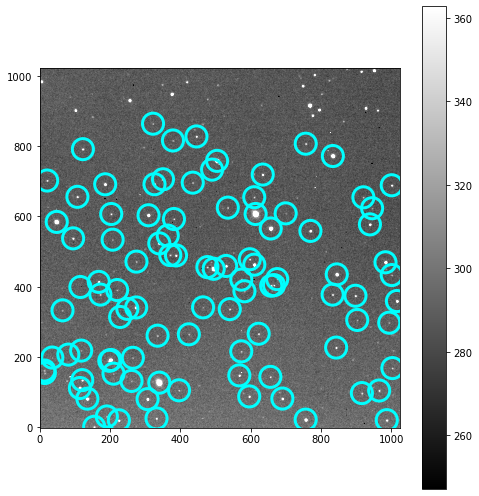

     xcentroid   ycentroid       mag
76  613.805328  607.071598 -6.772569
14  339.695722  127.242275 -6.522696
56  494.576172  451.209144 -4.926259
91  504.123563  758.245229 -4.873862
72   47.970181  584.582141 -4.802679
..         ...         ...       ...
29  117.496541  218.470964 -0.037163
78  945.226089  623.551748 -0.030125
37   64.408473  332.955349 -0.013489
48  115.232197  399.455022 -0.012907
12  395.808119  105.510170 -0.005797

[98 rows x 3 columns]
Point RA 23 41 52
Point Dec +44 11 06
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.46666667, 44.185)>
radecstr 355.467 44.185
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.23592792724

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.56722061e+02 1.60038472e+00 2.74461542e-01]
dyfit [ 5.56747357e+02 -2.74917676e-01  1.59943426e+00]

scalex, scaley: 0.6158587831587532 0.6161849721898178
anglex, angley: -9.731399917679818 -9.752943806593244
fracdiffs: 0.002213853001178664 0.0005296490688849105

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_002V.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_002V.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_002V.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201020/Reduced_Images/BDF_HH_And_002V.match.transfo

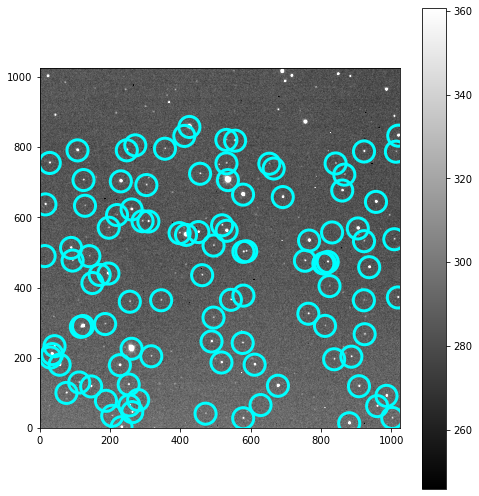

      xcentroid   ycentroid       mag
86   534.995389  705.886904 -6.896867
28   260.791796  226.074164 -6.676337
65   415.796934  550.054117 -5.112620
104  425.420223  857.118936 -4.876111
81   578.031722  664.663269 -4.540204
..          ...         ...       ...
75   219.535709  606.479103 -0.040354
89   665.218679  738.831400 -0.039464
67   831.324624  556.960539 -0.023128
24    30.150690  201.131441 -0.016518
44   579.137200  377.248536 -0.015256

[105 rows x 3 columns]
Point RA 23 41 58
Point Dec +44 10 06
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.49166667, 44.16833333)>
radecstr 355.492 44.1683
Search radius = 0.13106342470013851 deg


/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
355.64099415478967  44.12772121179612       11.152063
355.50456763922585  44.06754318511075       11.603616
355.41842256644543  44.05138045696271       11.614873
 355.3698096839802  44.17781222041276       12.348801
355.47001979053437  44.22036113755551       12.442065
355.52571998929113  44.25459544396694       12.642408
 355.5469803797695  44.23222573087555       12.708231
               ...                ...             ...
 355.6486785375408 44.129677573955405       13.829346
355.61449914440567  44.08852199648485       13.837882
 355.5413980430078   44.0704101181017      13.8390465
 355.5720328787715  44.08194082025348       13.874222
355.43035433548386   44.1886

287.67203771439216 12.4885913129203
227.86819048315908 362.7777089187888


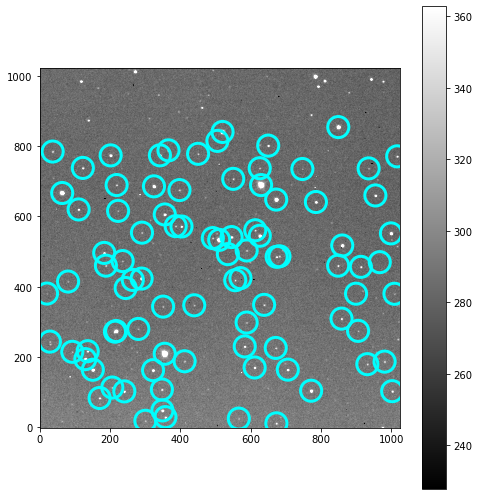

     xcentroid   ycentroid       mag
73  629.337788  689.329714 -6.628053
19  355.162661  209.474055 -6.396958
54  510.124394  533.517019 -4.777705
69   63.481888  666.888286 -4.675491
87  519.665583  840.535295 -4.626372
..         ...         ...       ...
36   20.308578  380.777620 -0.052922
38   80.239031  414.962283 -0.044366
50  534.866992  492.946281 -0.014224
1   300.185416   18.773792 -0.011076
64  222.549483  615.943665 -0.006280

[89 rows x 3 columns]
Point RA 23 41 52
Point Dec +44 10 06
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.46666667, 44.16833333)>
radecstr 355.467 44.1683
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.23592

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)


In [13]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*V.fit')

for path in pathlist:
    #show_image(Rimage)
    Vimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Vimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Vimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)


Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.

